In [10]:
import FundamentalAnalysis as fa
import matplotlib.pyplot as plt
import pandas as pd
import datetime as dt
import numpy as np
import time
# from nltk.sentiment.vader import SentimentIntensityAnalyzer
from datetime import timedelta

fa_api_key = '0531b0516802b6f762a2fe685575e4f0'
ticker = 'AMZN'
subreddits = ['teslainvestorsclub']

# Get Fundamental Data

In [11]:
balance_sheet_quarterly = fa.balance_sheet_statement(ticker, fa_api_key, period="quarterly")
cash_flow_statement_quarterly = fa.cash_flow_statement(ticker, fa_api_key, period="quarter")
financial_ratios_quarterly = fa.financial_ratios(ticker, fa_api_key, period="quarter")
financial_statement_growth = fa.financial_statement_growth(ticker, fa_api_key, period="quarter")
key_metrics = fa.key_metrics(ticker, fa_api_key, period="quarter")

roe = financial_ratios_quarterly.loc['returnOnEquity']
gross_profit_margin = financial_ratios_quarterly.loc['grossProfitMargin'] 
operating_profit_margin = financial_ratios_quarterly.loc['operatingProfitMargin'] 
pretaxProfitMargin = financial_ratios_quarterly.loc['pretaxProfitMargin']
netProfitMargin = financial_ratios_quarterly.loc['netProfitMargin']

revenue_growth = financial_statement_growth.loc['revenueGrowth']
gross_profit_growth = financial_statement_growth.loc['grossProfitGrowth']
ebit_growth = financial_statement_growth.loc['ebitgrowth']

fmtls_df = pd.DataFrame({'roe': roe, 
                         'grossProfitMargin': gross_profit_margin, 
                         'operatingProfitMargin': operating_profit_margin,
                         'pretaxProfitMargin': pretaxProfitMargin,
                         'netProfitMargin': netProfitMargin,
                         'revenueGrowth': revenue_growth,
                         'ebitGrowth': ebit_growth, 
                         'grossProfitGrowth': gross_profit_growth})

fmtls_df.index = pd.to_datetime(fmtls_df.index)
fmtls_df = fmtls_df[fmtls_df.index.year >= 2020]
fmtls_df = fmtls_df.sort_index()
fmtls_df

ValueError: Limit Reach . Please upgrade your plan or visit our documentation for more details at https://financialmodelingprep.com/developer/docs/pricing 

# Get Technical Data

In [4]:
weekly_stock_data = fa.stock_data(ticker, period='1y', interval='1wk')
daily_stock_data = fa.stock_data(ticker, period='1y', interval='1d')
daily_stock_data.index = pd.to_datetime(daily_stock_data.index)

weekly_stock_data = weekly_stock_data[['close', 'open']]
weekly_stock_data['next_week_gain'] = (weekly_stock_data.loc[:,'close'].shift(-1) / weekly_stock_data.loc[:,'close']) - 1
weekly_stock_data.dropna(inplace=True)

wks_of_interest = weekly_stock_data[abs(weekly_stock_data['next_week_gain']) > 0.10]
wks_of_interest.index = pd.to_datetime(wks_of_interest.index)
wks_of_interest = wks_of_interest[wks_of_interest.index.year == 2020]
wks_of_interest['int_idx'] = np.linspace(1, len(wks_of_interest), num=len(wks_of_interest))

# Graph it all (make it cool and readable)

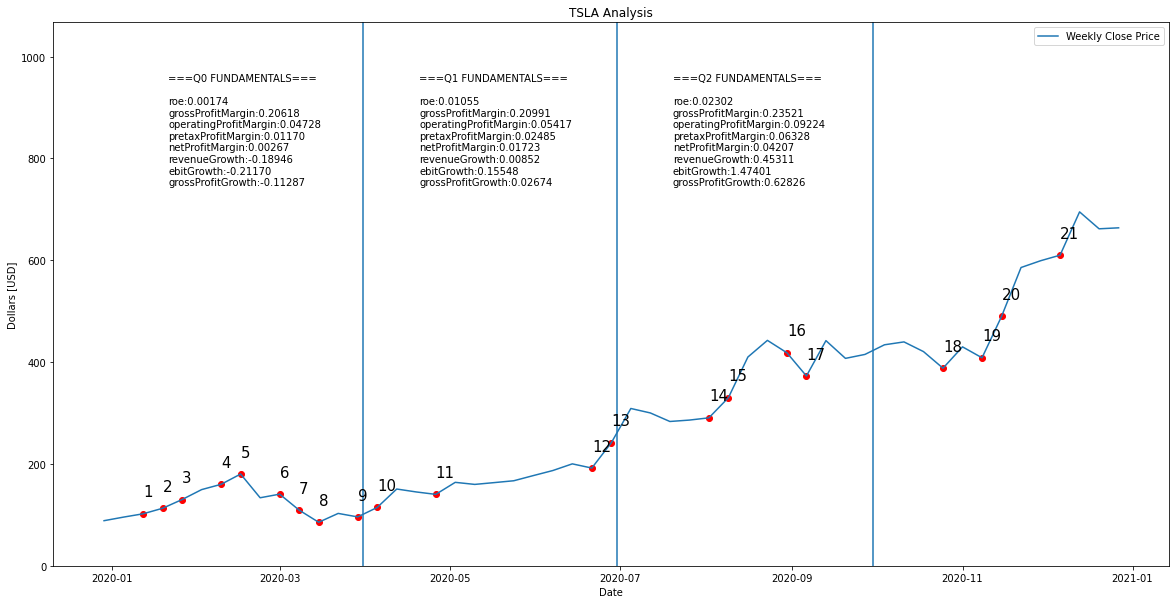

In [5]:
qtr_dates = [pd.to_datetime('2020-01-01'),
            pd.to_datetime('2020-03-31'), 
            pd.to_datetime('2020-06-30'), 
            pd.to_datetime('2020-09-30')]

ylim_max = max(wks_of_interest['close']) * 1.75
fig,ax1 = plt.subplots(figsize=(20,10), sharex=True)

ax1.set_ylim(0,ylim_max)

# Graph 1
ax1.plot(weekly_stock_data['close'], label=f'Weekly Close Price')
ax1.scatter(wks_of_interest.index, wks_of_interest['close'][wks_of_interest.index], color='r')
for i, y in enumerate(wks_of_interest.index):
    ax1.annotate(f'{i+1}\n', (y, wks_of_interest['close'][y]), fontsize=15)
# insert fundamentals
for date in qtr_dates[1:]:
    ax1.axvline(date)
    
    
qtr_count = 0
for idx, row in fmtls_df[fmtls_df.index.year >= 2020].iterrows():
    qrty_funda_str = f'===Q{qtr_count} FUNDAMENTALS===\n\n' + '\n'.join(f'{colname}:{row[colname]:.5f}' for colname in row.index)
    ax1.annotate(qrty_funda_str, 
                 xy=(qtr_dates[qtr_count] + dt.timedelta(days=20), 0.7 * ylim_max),
                xycoords='data')
    qtr_count += 1
    
plt.title(f'{ticker} Analysis')
plt.legend()
plt.xlabel('Date')
plt.ylabel('Dollars [USD]')
plt.show()

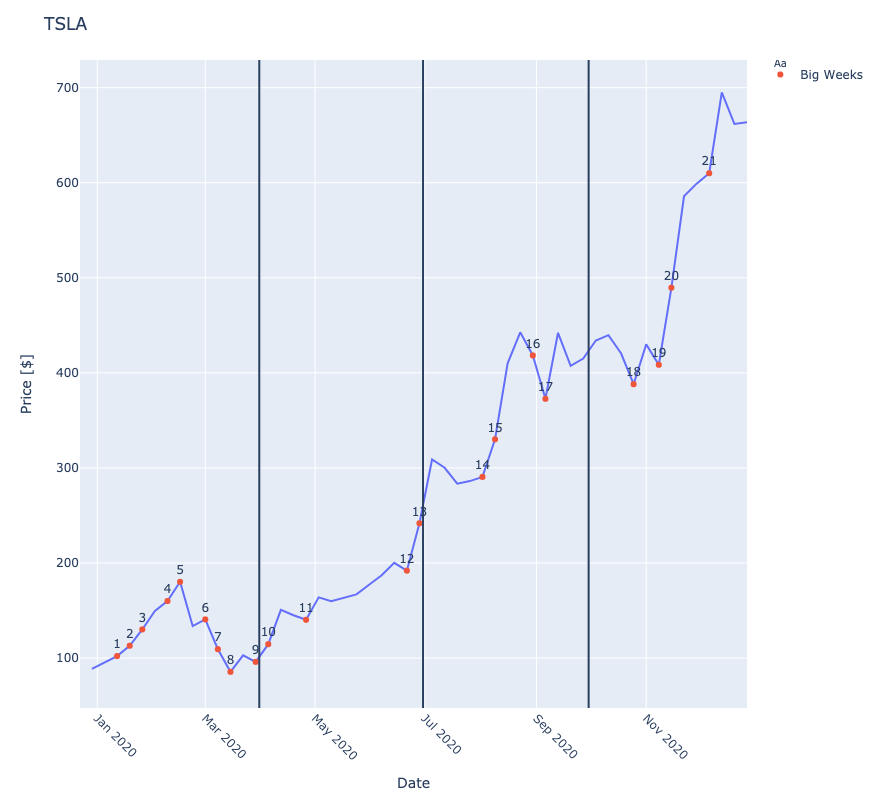

In [7]:
import plotly.express as px
import plotly.graph_objects as go
# from plotly.offline import init_notebook_mode, iplot
# init_notebook_mode()

fig = px.line(x=weekly_stock_data['close'].index, 
              y=weekly_stock_data['close'])
fig.add_trace(go.Scatter(x=wks_of_interest.index, 
                         y=wks_of_interest['close'][wks_of_interest.index],
                         text=wks_of_interest['int_idx'],
                         mode='markers+text',
                         textposition="top center",
                         name='Big Weeks'))



for i in range(1,4):
    fig.add_vline(x=qtr_dates[i])
    
fig.update_xaxes(type='date')
fig.update_layout(
    title=f"{ticker}",
    xaxis_title="Date",
    yaxis_title="Price [$]",
    autosize=True,
    width=1300,
    height=800
)



fig.update_xaxes(tickangle=45)
fig.show()

# Get Reddit Links around the times of the points of interest

In [119]:
# Get Reddit Links around the times of the points of interest
import requests

def get_epoch_date_range_for_reddit(date, day_buffer):
    left_date = date - dt.timedelta(days=day_buffer)
    return get_datetime_epoch(str(left_date)), get_datetime_epoch(str(date))

def get_request_uri(subreddit, after, before, size):
#     uri = (f'https://api.pushshift.io/reddit/search/submission?'
#            f'subreddit={subreddit}&after={after}&before={before}&size={size}')
    uri = (f'https://api.pushshift.io/reddit/search/submission?'
           f'subreddit={subreddit}&after={after}&before={before}'
           f'&size={size}&sort=asc&sort_type=created_utc')

    return uri

def make_request(uri, max_retries = 5):
    def fire_away(uri):
        response = requests.get(uri)
        assert response.status_code == 200
        return json.loads(response.content)['data']
    current_tries = 1
    while current_tries < max_retries:
        try:
            time.sleep(1)
            response = fire_away(uri)
            return response
        except:
            time.sleep(1)
            current_tries += 1
    return fire_away(uri)

def get_datetime_epoch(date_str):
    return int(dt.datetime.strptime(date_str, '%Y-%m-%d %H:%M:%S').timestamp())

def get_lastest_create_post_time(data, end_date_epoch):
    try: 
        latest_create_time = max(data, key=lambda x: x['created_utc'])['created_utc']
    except ValueError: 
        latest_create_time = end_date_epoch + 1
    return latest_create_time

def get_earliest_create_post_time(data, end_date_epoch):
    try: 
        latest_create_time = min(data, key=lambda x: x['created_utc'])['created_utc']
    except ValueError: 
        latest_create_time = end_date_epoch + 1
    return latest_create_time

def process_data(data):
    processed_data = []

    for post in data: 
        tmp = {}
        tmp['created_utc'] = post['created_utc']
        tmp['url'] = post['url']
        tmp['id'] = post['id']
        tmp['num_comments'] = post['num_comments']
        try:
            tmp['selftext'] = post['selftext']
        except KeyError: 
            tmp['selftext'] = ''
        tmp['title'] = post['title']
        processed_data.append(tmp)
    return processed_data

def get_all_posts(start_date_epoch, end_date_epoch, subreddit_name, size=100): 
    req_uri = get_request_uri(subreddit_name, start_date_epoch, end_date_epoch, size=size)
    data = make_request(req_uri)
    post_data = process_data(data)
    print(f'len post data: {len(post_data)}')

    if len(post_data) >= size: 
        last_created_post_time = get_lastest_create_post_time(post_data, end_date_epoch)
        print(f'latest:{last_created_post_time} - end:{end_date_epoch}')
        while last_created_post_time < end_date_epoch:
            req_uri = get_request_uri(subreddit_name, last_created_post_time, end_date_epoch, size=size)
            data = make_request(req_uri)
            new_data = process_data(data)
            print(f'len new data: {len(new_data)}')
            post_data.extend(new_data)
            last_created_post_time = get_lastest_create_post_time(new_data, end_date_epoch)
            print(f'latest:{last_created_post_time} - end:{end_date_epoch}')

    return post_data
            

def get_sentiment_of_reddit_titles(port_titles):
    sid = SentimentIntensityAnalyzer()
    sentiments = {'neu': [], 
                 'pos': [], 
                 'neg': []}
    for title in post_titles:
        ss = sid.polarity_scores(title)
        print(title)
        print(ss)
    #     sentiments['compound'].append(ss['compound'])
        sentiments['neu'].append(ss['neu'])
        sentiments['pos'].append(ss['pos'])
        sentiments['neg'].append(ss['neg'])
    df = pd.DataFrame(sentiments)
    return df    

In [120]:
x = wks_of_interest.index[2]
start_date_epoch, end_date_epoch = get_epoch_date_range_for_reddit(x, 7)
print(f'start:{start_date_epoch}, end:{end_date_epoch}')

start:1579420800, end:1580025600


In [121]:
post_data = get_all_posts(start_date_epoch, end_date_epoch, subreddits[0])

len post data: 100
latest:1579828164 - end:1580025600
len new data: 63
latest:1580020321 - end:1580025600
len new data: 0
latest:1580025601 - end:1580025600


In [122]:
post_titles = []
for post in post_data: 
    post_titles.append(post['title'])
print(len(post_titles))

163


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f7f48be9c90>,
      dtype=object)

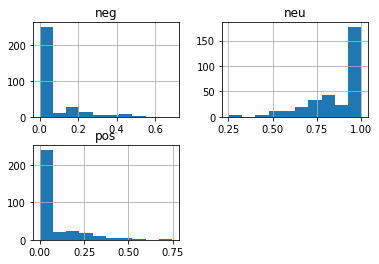

In [123]:
df.hist()